# Lab 01

## Preprocessing

### Downloading and extracting the Data

In [1]:
# !wget https://technionmail-my.sharepoint.com/:u:/g/personal/ploznik_campus_technion_ac_il/EQc79uRBeO1FqtH6ILFDx78BuuWui3DuRaBtnzTB6Aqxqg?download=1 -O data.tar 
# !tar -xvf data.tar

### Read the relevant data from all the files

In [2]:
import pandas as pd
import os

In [3]:
def read_data(filepath,datatable):
    "Reusable function to read PSV data from source directory"
    count = 0
    rows = 0
    for filename in os.listdir(filepath):
        if filename.endswith(".psv"): 
            with open(filepath + filename) as openfile:
                patient = filename.split(".")[0]

                file = pd.read_csv(openfile,sep = "|")
                file['Patient_ID'] = patient
                
                file = file.reset_index()
                file = file.rename(columns={"index": "Hour"})
                
                index = file.loc[file['SepsisLabel'] == 1].index.min()
                # create new dataframe with data up to and including the row with SepsisLabel = 1
                file = file.loc[:index]
                datatable = pd.concat([datatable, file])
                
                rows += file.size
                count += 1
        # Print progress after 10k files
        if count % 1000 == 0:
            print("Progress || Files: {} || Number of items: {}".format(count,rows))
    print("Done ||| Files: {} || Number of items: {}".format(count,rows))
    return(datatable)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/Shareddrives/Guy_Noam_Shared_Drive/Lab_2/HW1_Spesis_prediction

/content/drive/Shareddrives/Guy_Noam_Shared_Drive/Lab_2/HW1_Spesis_prediction


In [6]:
# test_path = "/content/data/test/"
# df = pd.DataFrame()
# data = read_data(test_path,df)
# data.to_csv("test.csv")

In [7]:
# train_path = "/content/data/train/"
# df = pd.DataFrame()
# data = read_data(train_path,df)
# data.to_csv("train.csv")

In [8]:
train_df = pd.read_csv('/content/drive/Shared drives/Guy_Noam_Shared_Drive/Lab_2/HW1_Spesis_prediction/train.csv')
test_df = pd.read_csv('/content/drive/Shared drives/Guy_Noam_Shared_Drive/Lab_2/HW1_Spesis_prediction/test.csv')

### Preprocess

In [9]:
# Create dictionary to specify the aggregation:

wide_features = [ 'HR' ,'O2Sat' ,'Temp' ,'SBP' ,'MAP' ,'DBP' ,'Resp' ,'EtCO2' ,'BaseExcess' ,'HCO3' ,'FiO2' ,'pH' ,'PaCO2' ,'SaO2' ,'AST' ,'BUN' ,'Alkalinephos' ,'Calcium' ,'Chloride' ,'Creatinine' ,'Bilirubin_direct' ,'Glucose' ,'Lactate' ,'Magnesium' ,'Phosphate' ,'Potassium' ,'Bilirubin_total' ,'TroponinI' ,'Hct' ,'Hgb' ,'PTT' ,'WBC' ,'Fibrinogen' ,'Platelets']
wide_metrics = ['max', 'min', 'mean', 'count', 'first', 'last', "std"]

narrow_features = ['Age', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel', 'Hour']

agg_dict = {k: wide_metrics for k in wide_features}
narrow_dict = {k: 'last' for k in narrow_features}
agg_dict.update(narrow_dict)

In [10]:
train_agg = train_df.copy()
test_agg = test_df.copy()

In [11]:
# import pandas as pd
# from sklearn.impute import KNNImputer

# # create sample dataframe
# df = train_agg.copy()

# # get the number of rows in the dataframe
# num_rows = len(df)

# # drop columns with more than 20% nulls
# df = df.dropna(thresh=num_rows*0.8, axis=1)

# # use KNNImputer on remaining columns
# imputer = KNNImputer(n_neighbors=5)
# df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# test = test_agg.copy()

# # drop columns with more than 20% nulls
# test = test[df.columns]
# test_imputed = pd.DataFrame(imputer.transform(test), columns=test.columns)

In [12]:
train_agg = train_agg.groupby('Patient_ID').agg(agg_dict)
test_agg = test_agg.groupby('Patient_ID').agg(agg_dict)

In [13]:
def one_out(gdf):
  # onehot encoding the gender
  one_hot = pd.get_dummies(gdf[('Gender','last')])

  # create a new hierarchical index
  new_columns = pd.MultiIndex.from_arrays([['Gender','Gender'], one_hot.columns])
  # assign the new index to the DataFrame columns
  one_hot.columns = new_columns


  #merge back to the df
  gdf = gdf.merge(one_hot, on='Patient_ID')
  gdf = gdf.drop(('Gender','last'), axis=1)
  return gdf

train_agg = one_out(train_agg)
test_agg = one_out(test_agg)


<ipython-input-13-8567673ea142>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gdf = gdf.merge(one_hot, on='Patient_ID')
<ipython-input-13-8567673ea142>:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  gdf = gdf.merge(one_hot, on='Patient_ID')


In [14]:
for i in wide_features:
  train_agg[(i, "range")] = train_agg[(i, "max")] -  train_agg[(i, "min")]
  test_agg[(i, "range")] = test_agg[(i, "max")] -  test_agg[(i, "min")]

<ipython-input-14-f44e1eca0d26>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_agg[(i, "range")] = train_agg[(i, "max")] -  train_agg[(i, "min")]
<ipython-input-14-f44e1eca0d26>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_agg[(i, "range")] = test_agg[(i, "max")] -  test_agg[(i, "min")]


## EDA

In [ ]:
train_agg.describe()

HR                                                          \
                max           min          mean         count         first   
count  19822.000000  19822.000000  19822.000000  20000.000000  19822.000000   
mean     101.896025     69.680027     83.747642     33.984650     84.733781   
std       19.279005     13.870612     14.620389     21.092581     18.202372   
min       45.000000     20.000000     33.360000      0.000000     30.000000   
25%       88.500000     60.000000     73.407366     21.000000     72.000000   
50%      100.000000     69.000000     83.031010     35.000000     83.500000   
75%      114.000000     78.000000     93.097209     43.000000     95.500000   
max      280.000000    140.500000    174.037975    333.000000    178.000000   

                                          O2Sat                              \
               last           std           max           min          mean   
count  19822.000000  19768.000000  19809.000000  19809.000000  19809.000000   
mean      83.627031      8.267106     99.553637     91.958150     97.152698   
std       16.742173      4.070395      1.310843      6.784052      2.182043   
min       20.000000      0.000000     27.000000     20.000000     27.000000   
25%       72.000000      5.540693    100.000000     91.000000     96.145161   
50%       82.000000      7.514646    100.000000     93.000000     97.406250   
75%       94.000000     10.172390    100.000000     95.000000     98.500000   
max      200.000000     52.014775    100.000000    100.000000    100.000000   

       ...     Phosphate     Potassium Bilirubin_total    TroponinI  \
       ...         range         range           range        range   
count  ...  13736.000000  18806.000000     6839.000000  3479.000000   
mean   ...      0.650011      0.594723        0.259709     2.973705   
std    ...      0.932313      0.720268        1.061633    15.119209   
min    ...      0.000000      0.000000        0.000000     0.000000   
25%    ...      0.000000      0.040000        0.000000     0.000000   
50%    ...      0.300000      0.400000        0.000000     0.000000   
75%    ...      1.000000      0.900000        0.100000     0.190000   
max    ...     13.800000     24.400000       29.300000   391.490000   

                Hct           Hgb          PTT           WBC   Fibrinogen  \
              range         range        range         range        range   
count  18596.000000  18519.000000  9769.000000  18435.000000  2181.000000   
mean       3.335381      1.033262    10.059859      2.454242    43.027969   
std        3.755300      1.288282    25.315194      4.995161    91.280413   
min        0.000000      0.000000     0.000000      0.000000     0.000000   
25%        0.100000      0.000000     0.000000      0.000000     0.000000   
50%        2.300000      0.600000     0.400000      1.300000     0.000000   
75%        5.000000      1.500000     5.900000      3.500000    52.000000   
max       31.700000     14.900000   223.700000    374.000000  1098.000000   

          Platelets  
              range  
count  18450.000000  
mean      28.093957  
std       39.224870  
min        0.000000  
25%        0.000000  
50%       16.000000  
75%       40.000000  
max      695.000000  

[8 rows x 281 columns]

#### Labeling balance

In [ ]:
train_agg[("SepsisLabel", "last")].value_counts()[1] / (train_agg[("SepsisLabel", "last")].value_counts()[1] + train_agg[("SepsisLabel", "last")].value_counts()[0])

0.07075

Text(0.5, 1.0, 'Label balance')

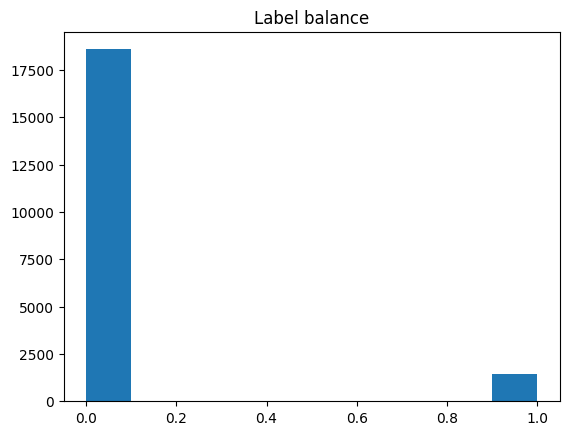

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.hist(train_agg[("SepsisLabel", "last")])
plt.title('Label balance')


#### Null values

In [ ]:
# checking missing data
total = train_agg.isnull().sum().sort_values(ascending = False)
percent = (train_agg.isnull().sum()/train_agg.isnull().count()*100).sort_values(ascending = False)
missing_train_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_train_data.head(20)

Total  Percent
Bilirubin_direct std    19763   98.815
Fibrinogen       std    19042   95.210
Bilirubin_direct max    19040   95.200
                 first  19040   95.200
                 min    19040   95.200
                 mean   19040   95.200
                 range  19040   95.200
                 last   19040   95.200
EtCO2            std    18621   93.105
                 last   18508   92.540
                 max    18508   92.540
                 min    18508   92.540
                 mean   18508   92.540
                 first  18508   92.540
                 range  18508   92.540
TroponinI        std    18106   90.530
Fibrinogen       mean   17819   89.095
                 min    17819   89.095
                 max    17819   89.095
                 first  17819   89.095

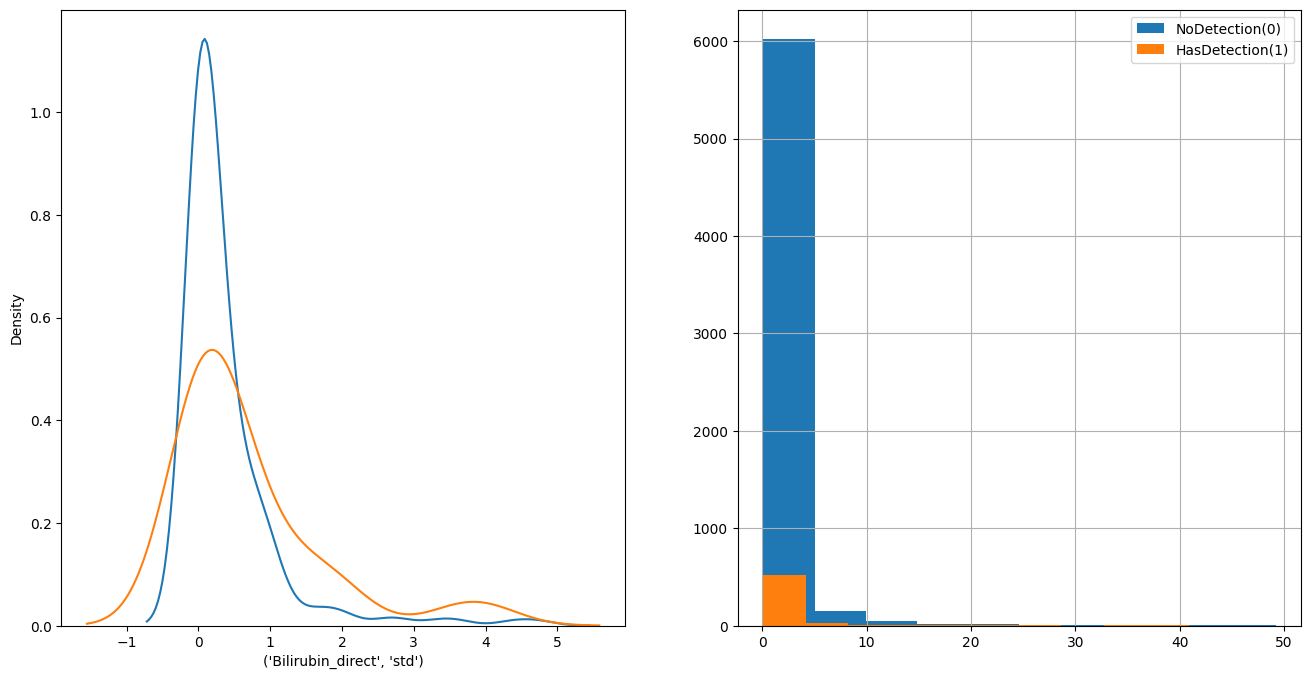

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
sns.kdeplot(train_agg.loc[train_agg[("SepsisLabel", "last")] == 0, ('Bilirubin_direct', "std")], ax=ax[0], label='NoDetection(0)')
sns.kdeplot(train_agg.loc[train_agg[("SepsisLabel", "last")] == 1, ('Bilirubin_direct', "std")], ax=ax[0], label='HasDetection(1)')

train_agg.loc[train_agg[("SepsisLabel", "last")] == 0, ('Bilirubin_total', "mean")].hist(ax=ax[1])
train_agg.loc[train_agg[("SepsisLabel", "last")] == 1, ('Bilirubin_total', "mean")].hist(ax=ax[1])
ax[1].legend(['NoDetection(0)', 'HasDetection(1)'])

plt.show()

In [ ]:
rel = [("SepsisLabel", "last")]
for f in wide_features:
  rel.append((f,"mean"))
# for i in rel:
#     sns.distplot(train_agg[i])
#     plt.show()
#     print("\n\n")







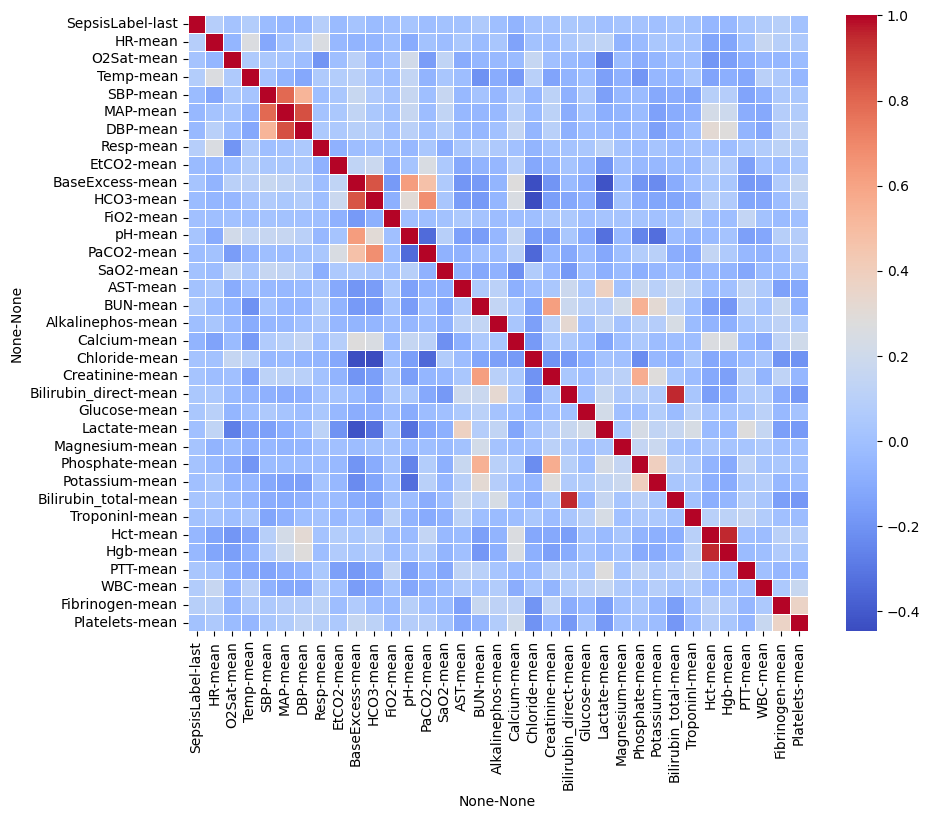

In [ ]:
corr_matrix = train_agg[rel].corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, linewidths=0.5)
plt.show()

In [ ]:
import scipy.stats as stats
hypothesis_test_list = [("HR", "mean"), ("Temp", "mean"), ("Resp", "mean"), ("Hour", "last")]
for feature_to_h_test in hypothesis_test_list:
  train_agg_h = train_agg.dropna(subset=[feature_to_h_test , ("SepsisLabel", "last")])
  print(feature_to_h_test[0])
  pearson_corr, p_value = stats.pearsonr(train_agg_h[feature_to_h_test].dropna(), train_agg_h[("SepsisLabel", "last")].dropna())
  spearman_corr, p_value = stats.spearmanr(train_agg_h[feature_to_h_test].dropna(), train_agg_h[("SepsisLabel", "last")].dropna())

  # Print the correlation coefficient and p-value
  print("Pearson correlation coefficient:", pearson_corr)
  print("p-value:", p_value)

  # Print the correlation coefficient and p-value
  print("Spearman correlation coefficient:", spearman_corr)
  print("p-value:", p_value)
  print()

HR
Pearson correlation coefficient: 0.08676050293844312
p-value: 1.1159739931158494e-28
Spearman correlation coefficient: 0.07879694263537805
p-value: 1.1159739931158494e-28

Temp
Pearson correlation coefficient: 0.07806364142199171
p-value: 3.661689054333033e-27
Spearman correlation coefficient: 0.07690083801793993
p-value: 3.661689054333033e-27

Resp
Pearson correlation coefficient: 0.08521983176877819
p-value: 1.760133880460425e-24
Spearman correlation coefficient: 0.07250691307057892
p-value: 1.760133880460425e-24

Hour
Pearson correlation coefficient: 0.15529394123350945
p-value: 1.7053630622031458e-10
Spearman correlation coefficient: -0.04513402958862084
p-value: 1.7053630622031458e-10



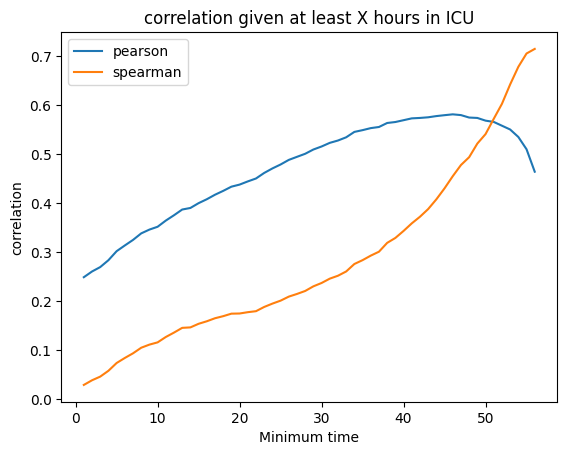

[4.00177379350511e-05, 5.3434762354189466e-08, 8.769182870782103e-11, 3.6047161193961064e-16, 3.130166662206323e-25, 3.1466272405073034e-32, 2.0623083134702938e-39, 5.987844437056799e-49, 1.1751834943956591e-54, 7.365387778429545e-59, 8.593473007062285e-70, 3.9929697454033494e-79, 1.2363916805479167e-89, 1.2632371573281956e-89, 3.277181721681559e-97, 8.989014973377059e-102, 2.1093757133453487e-107, 6.336720714205146e-110, 1.6887781344915477e-113, 1.2039778974075735e-110, 1.1539001734284419e-110, 1.0709657003364189e-109, 3.6935620104427496e-117, 1.6940402965197265e-122, 6.4845169596939385e-127, 2.0014046265703698e-134, 7.722668004299764e-139, 1.3400099675771376e-144, 5.755407830220599e-155, 6.317668320288067e-162, 4.4508076606967014e-172, 5.538135242004817e-178, 2.5019744275905714e-187, 5.881050427401713e-206, 4.7863419859201035e-206, 3.7857545225748065e-208, 4.69442716884427e-206, 9.480985843164116e-217, 7.583147947386485e-216, 4.7473617447536305e-219, 1.4946449543074246e-223, 2.793499

In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

feature_to_h_test= ("Hour", "last")
train_agg_h = train_agg.dropna(subset=[feature_to_h_test , ("SepsisLabel", "last")])

treshold_hours = [i for i in range(1,57)]
pearson_vals = []
pearson_p_vals = []

spearman_vals = []
spearman_p_vals = []

for treshold_hour in treshold_hours:
  train_agg_h = train_agg_h[train_agg_h[("Hour", "last")] > treshold_hour]
  pearson_corr, p_value = stats.pearsonr(train_agg_h[feature_to_h_test].dropna(), train_agg_h[("SepsisLabel", "last")].dropna())
  pearson_vals.append(pearson_corr)
  pearson_p_vals.append(p_value)

  spearman_corr, p_value = stats.spearmanr(train_agg_h[feature_to_h_test].dropna(), train_agg_h[("SepsisLabel", "last")].dropna())
  spearman_vals.append(spearman_corr)
  spearman_p_vals.append(p_value)

plt.plot(treshold_hours, pearson_vals, label='pearson')
plt.plot(treshold_hours, spearman_vals, label='spearman')

plt.xlabel('Minimum time')
plt.ylabel('correlation')
plt.title('correlation given at least X hours in ICU')

plt.legend()
plt.show()
print(spearman_p_vals)
print(pearson_p_vals)

# tests

In [ ]:
# columns_impute = list(b.columns)
# # bfill and ffill for imputing

# grouped_by_patient = b.groupby('Patient_ID')
# b_impute = grouped_by_patient.apply(lambda x: x.bfill().ffill())


In [ ]:
# null_values = b_impute.isnull().mean()*100
# null_values = null_values.sort_values(ascending=False)
# null_values[null_values > 25]

In [ ]:
# # dropping all the columns with null values more than 25% and patient_id

# null_col = ['TroponinI', 'Bilirubin_direct', 'AST', 'Bilirubin_total', 'Lactate', 'SaO2', 'FiO2',
#             'Unit1', 'Patient_ID', "EtCO2", "Fibrinogen", "BaseExcess", "Alkalinephos", "PaCO2", "HCO3", "pH", "PTT", "Chloride", "Unit2","Phosphate"] 
# b_impute = b_impute.drop(columns=null_col)
# b_impute.columns

In [ ]:
# # onehot encoding the gender

# one_hot = pd.get_dummies(b_impute['Gender'])
# b_impute = b_impute.join(one_hot)
# b_impute = b_impute.drop('Gender', axis=1)

In [ ]:
# # function to draw histogram and QQ plot 

# def diagnostic_plots(df, variable):
#     fig = plt.figure(figsize=(15,4))
#     ax = fig.add_subplot(121)
#     df[variable].hist(bins=30)
#     ax = fig.add_subplot(122)
#     stats.probplot(df[variable], dist="norm", plot=plt)
#     plt.xlabel(variable)
#     plt.show()

In [ ]:
# # function to apply different transformations to make the plot gaussian

# def try_gaussian(df, col):
#   print('actual plot')
#   diagnostic_plots(df,col)
#   # this applies yeojohnson plot
#   df['col_yj'], param = stats.yeojohnson(df[col]) 
#   print('yeojohnson plot')
#   diagnostic_plots(df, 'col_yj')
#   # this applies exponential transformation
#   df['col_1.5'] = df[col]**(1/1.5)
#   print('**1/1.5 plot') 
#   diagnostic_plots(df, 'col_1.5')
#   df['col_.5'] = df[col]**(.5)
#   print('**.5 plot') 
#   # this applies inverse transformation
#   diagnostic_plots(df, 'col_.5')
#   df['col_rec'] = 1 / (df[col]+0.00001) 
#   diagnostic_plots(df, 'col_rec')
#   # this applies logarithmic trasnformation
#   df['col_log'] = np.log(df[col]+1)
#   diagnostic_plots(df, 'col_log')  

In [ ]:
# import matplotlib.pyplot as plt 
# import scipy.stats as stats
# import numpy as np

# for i in wide_features:
#   print(i)
#   try_gaussian(gdf, (i,'mean'))

In [ ]:
# gdf.columns

MultiIndex([(         'HR',   'max'),
            (         'HR',   'min'),
            (         'HR',  'mean'),
            (         'HR', 'count'),
            (         'HR', 'first'),
            (         'HR',  'last'),
            (      'O2Sat',   'max'),
            (      'O2Sat',   'min'),
            (      'O2Sat',  'mean'),
            (      'O2Sat', 'count'),
            ...
            (     'ICULOS',  'last'),
            ('SepsisLabel',  'last'),
            (       'Hour',  'last'),
            (     'Gender',       0),
            (     'Gender',       1),
            (     'col_yj',      ''),
            (    'col_1.5',      ''),
            (     'col_.5',      ''),
            (    'col_rec',      ''),
            (    'col_log',      '')],
           length=218)

In [ ]:
# gdf = gdf.drop(columns = ['col_yj','col_1.5','col_.5','col_rec','col_log'])

<ipython-input-70-64d1b9fe8912>:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  gdf = gdf.drop(columns = ['col_yj','col_1.5','col_.5','col_rec','col_log'])


In [ ]:
# *************
# TODO - CONSIDER NORMALIZING HERE!!!!!





# columns_normalized = ['MAP', 'BUN', 'Creatinine', 'Glucose', 'WBC', 'Platelets' ]
# for i in columns_normalized:
#   for j in wide_metrics:
#     gdf[(i,j)] = np.log(gdf[(i,j)]+1)

In [ ]:
# b_impute = b_impute.drop(columns = ["DBP"])

In [ ]:
# for i in b_impute.columns:
#   b_impute[i].fillna(b_impute[i].mean(), inplace=True)


In [ ]:
# b_impute = b_impute.dropna()

In [ ]:
# from sklearn.preprocessing import StandardScaler
# # gdf.columns = gdf.columns.astype(str)
# scaler = StandardScaler()
# normalized = pd.DataFrame(scaler.fit_transform(gdf), columns=gdf.columns)

# normalized.head()

In [ ]:
# normalized["SepsisLabel"] = [1 if i > 0 else 0 for i in normalized["SepsisLabel"]]


# Training

In [15]:
train_agg

HR                                                 O2Sat  \
                max   min       mean count  first  last        std    max   
Patient_ID                                                                  
patient_0      94.0  54.0  60.954545    22   61.0  55.0   8.144395  100.0   
patient_1     101.0  79.0  87.875000    24   81.0  98.0   6.930164  100.0   
patient_10    109.0  76.0  89.305556    36   85.0  81.0   7.532101  100.0   
patient_100    72.0  56.0  63.615385    13   69.0  67.0   5.424304  100.0   
patient_1000   96.0  70.0  79.704545    44   82.5  96.0   5.105080  100.0   
...             ...   ...        ...   ...    ...   ...        ...    ...   
patient_9995  104.0  77.0  88.943396    53   88.0  95.0   6.239345  100.0   
patient_9996  112.0  86.0  97.025000    40  110.0  90.0   6.510298  100.0   
patient_9997   97.0  65.0  78.031250    16   97.0  70.0   8.482273   98.0   
patient_9998   82.0  53.0  65.025000    40   64.5  76.0   8.222039   99.0   
patient_9999  106.0  64.0  87.375000     8   97.0  64.0  13.585050  100.0   

                                 ... Phosphate Potassium Bilirubin_total  \
                min        mean  ...     range     range           range   
Patient_ID                       ...                                       
patient_0      94.0   97.000000  ...       0.0       0.0             NaN   
patient_1     100.0  100.000000  ...       0.3       0.6             NaN   
patient_10     94.0   97.500000  ...       0.0       0.2             0.0   
patient_100    96.0   98.083333  ...       NaN       0.2             NaN   
patient_1000   95.0   98.476744  ...       0.7       0.1             0.0   
...             ...         ...  ...       ...       ...             ...   
patient_9995   92.0   96.773585  ...       9.2       0.3             NaN   
patient_9996   98.0   99.737500  ...       0.4       0.5             NaN   
patient_9997   94.0   95.937500  ...       NaN       0.3             0.0   
patient_9998   91.0   94.887500  ...       0.5       0.3             NaN   
patient_9999   96.0   96.750000  ...       0.0       0.2             NaN   

             TroponinI   Hct   Hgb   PTT   WBC Fibrinogen Platelets  
                 range range range range range      range     range  
Patient_ID                                                           
patient_0          NaN   0.0   0.0   NaN   0.0        NaN       0.0  
patient_1          NaN   6.3   0.9   1.4   1.9        NaN      40.0  
patient_10         NaN   1.4   0.5   0.0   0.0        NaN       0.0  
patient_100       0.00   0.4   0.1   NaN   2.4        NaN      24.0  
patient_1000       NaN   0.6   0.3   NaN   1.6        NaN       7.0  
...                ...   ...   ...   ...   ...        ...       ...  
patient_9995       NaN   1.9   0.7   NaN   0.6        NaN      13.0  
patient_9996       NaN   0.6   0.1   NaN   6.4        NaN      63.0  
patient_9997     23.15   1.5   0.5   NaN   2.9        NaN       6.0  
patient_9998      0.02   0.8   0.2   NaN   0.4        NaN       9.0  
patient_9999       NaN   2.2   0.7   NaN   3.2        NaN      28.0  

[20000 rows x 281 columns]

In [16]:
import numpy as np

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
train_agg = reduce_mem_usage(train_agg)

Memory usage of dataframe is 42.76 MB
Memory usage after optimization is: 10.38 MB
Decreased by 75.7%


In [ ]:
# # Assuming your data is stored in a pandas DataFrame called df
# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=2)
# train_imputed = pd.DataFrame(imputer.fit_transform(train_agg), columns=train_agg.columns)

In [ ]:
# # Assuming your data is stored in a pandas DataFrame called df
# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=2)
# test_imputed = pd.DataFrame(imputer.fit_transform(test_agg), columns=test_agg.columns)

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.combine import SMOTEENN

from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from sklearn.metrics import classification_report

# # Load the data
# data = gdf

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(data.drop(('SepsisLabel','last'), axis=1), 
#                                                     data[('SepsisLabel','last')], 
#                                                     test_size=0.2, 
#                                                     random_state=42)


X_train = train_agg.drop(('SepsisLabel','last'), axis=1).values
y_train = train_agg[('SepsisLabel','last')].values
X_test = test_agg.drop(('SepsisLabel','last'), axis=1).values
y_test = test_agg[('SepsisLabel','last')].values


# X_train = train_imputed.drop(('SepsisLabel','last'), axis=1)
# y_train = train_imputed[('SepsisLabel','last')]
# X_test = test_imputed.drop(('SepsisLabel','last'), axis=1)
# y_test = test_imputed[('SepsisLabel','last')]



# Resample the data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


# # Oversample minority class and undersample majority class using SMOTEENN
# sm = SMOTEENN(random_state=42)
# X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)




params = {'max_depth': 15,
            "n_estimators":100,
            'learning_rate': 0.3
            }

# Train the model
xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))
# Tune hyperparameters (example only, not exhaustive)
# params = {'max_depth': [15] ,
#           "n_estimators":[100, 200, 300]

# }
# grid_search = GridSearchCV(estimator=xgb_model, 
#                            param_grid=params, 
#                            scoring='f1', 
#                            cv=3, 
#                            n_jobs=-1)
# grid_search.fit(X_train_resampled, y_train_resampled)
# print(grid_search.best_params_)

from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9259
           1       0.87      0.64      0.74       741

    accuracy                           0.97     10000
   macro avg       0.92      0.82      0.86     10000
weighted avg       0.96      0.97      0.96     10000



0.7371695178849145

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.combine import SMOTEENN

from imblearn.over_sampling import RandomOverSampler
import xgboost as xgb
from sklearn.metrics import classification_report

# # Load the data
# data = gdf

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(data.drop(('SepsisLabel','last'), axis=1), 
#                                                     data[('SepsisLabel','last')], 
#                                                     test_size=0.2, 
#                                                     random_state=42)


X_train = df_imputed.drop(('SepsisLabel','last'), axis=1).values
y_train = df_imputed[('SepsisLabel','last')].values
X_test = test_imputed.drop(('SepsisLabel','last'), axis=1).values
y_test = test_imputed[('SepsisLabel','last')].values


# X_train = train_imputed.drop(('SepsisLabel','last'), axis=1)
# y_train = train_imputed[('SepsisLabel','last')]
# X_test = test_imputed.drop(('SepsisLabel','last'), axis=1)
# y_test = test_imputed[('SepsisLabel','last')]



# Resample the data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


# # Oversample minority class and undersample majority class using SMOTEENN
# sm = SMOTEENN(random_state=42)
# X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)






# Train the model
xgb_model = xgb.XGBClassifier(max_depth= 10, min_child_weight= 1)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

# # Tune hyperparameters (example only, not exhaustive)
# params = {'max_depth': [3, 5, 7], 
#           'n_estimators': [50, 100, 150], 
#           'learning_rate': [0.05, 0.1, 0.2]}
# grid_search = GridSearchCV(estimator=xgb_model, 
#                            param_grid=params, 
#                            scoring='roc_auc', 
#                            cv=3, 
#                            n_jobs=-1)
# grid_search.fit(X_train_resampled, y_train_resampled)
# print(grid_search.best_params_)

from sklearn.metrics import f1_score
f1_score(y_test, y_pred)

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      9259
         1.0       0.86      0.62      0.72       741

    accuracy                           0.96     10000
   macro avg       0.91      0.81      0.85     10000
weighted avg       0.96      0.96      0.96     10000



0.719435736677116

In [ ]:
import pickle
# Save the model as a pickle file
with open('model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

In [ ]:
# Import necessary libraries
import numpy as np
from sklearn.impute import KNNImputer

# Create a KNN imputer object
imputer = KNNImputer(n_neighbors=3)

# Impute the missing values in the data
X_imputed = imputer.fit_transform(X_train_resampled)


In [ ]:
X_imputed_test = imputer.fit_transform(X_test)


In [ ]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

# Create a logistic regression model
lr = LogisticRegression()

# Train the model using the training data
lr.fit(X_imputed, y_train_resampled)

# Make predictions on the testing data
y_pred = lr.predict(X_imputed_test)

# Evaluate the model's accuracy and F1 score
accuracy = lr.score(X_imputed_test, y_test)
f1 = f1_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("F1 Score:", f1)


Model Accuracy: 0.8047
F1 Score: 0.34791318864774623


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 8.2 MB/s eta 0:00:00


In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier

CBC = CatBoostClassifier(eval_metric='F1')
parameters = {'depth'         : [4,5,6,7,8,9, 10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
              'iterations'    : [10, 20,30,40,50,60,70,80,90, 100]
              }
Grid_CBC = GridSearchCV(estimator=CBC, param_grid = parameters, cv = 2, n_jobs=-1)
Grid_CBC.fit(X_train_resampled, y_train_resampled)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

In [ ]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",Grid_CBC.best_estimator_)
print("\n The best score across ALL searched params:\n",Grid_CBC.best_score_)
print("\n The best parameters across ALL searched params:\n",Grid_CBC.best_params_)

In [20]:
import catboost as cb
from sklearn.metrics import accuracy_score

# Create CatBoost classifier and fit on training data
params = {'bagging_temperature': 0.5, 'depth': 10, 'l2_leaf_reg': 2, 'learning_rate': 0.03, "eval_metric":'F1'}

clf = cb.CatBoostClassifier(**params)
clf.fit(X_train_resampled, y_train_resampled, eval_set=(X_test, y_test))

# Predict on test set and evaluate performance
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print('Accuracy:', acc)
f1 = f1_score(y_test, y_pred)
print("F1 Score:", f1)

0:	learn: 0.8531346	test: 0.5145455	best: 0.5145455 (0)	total: 2.3s	remaining: 38m 17s
1:	learn: 0.8601606	test: 0.5396518	best: 0.5396518 (1)	total: 4.36s	remaining: 36m 18s
2:	learn: 0.8639735	test: 0.5516894	best: 0.5516894 (2)	total: 7.75s	remaining: 42m 57s
3:	learn: 0.8666381	test: 0.5714286	best: 0.5714286 (3)	total: 10.9s	remaining: 45m 26s
4:	learn: 0.8739352	test: 0.5957447	best: 0.5957447 (4)	total: 13.6s	remaining: 45m 15s
5:	learn: 0.8787272	test: 0.6085526	best: 0.6085526 (5)	total: 15.7s	remaining: 43m 18s
6:	learn: 0.8817678	test: 0.6120879	best: 0.6120879 (6)	total: 17.8s	remaining: 42m 1s
7:	learn: 0.8804688	test: 0.6246483	best: 0.6246483 (7)	total: 19.7s	remaining: 40m 45s
8:	learn: 0.8844526	test: 0.6230986	best: 0.6246483 (7)	total: 23.3s	remaining: 42m 50s
9:	learn: 0.8836438	test: 0.6241535	best: 0.6246483 (7)	total: 25.8s	remaining: 42m 37s
10:	learn: 0.8831659	test: 0.6240180	best: 0.6246483 (7)	total: 28.3s	remaining: 42m 26s
11:	learn: 0.8869228	test: 0.6241

In [ ]:
import catboost as cb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix



# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

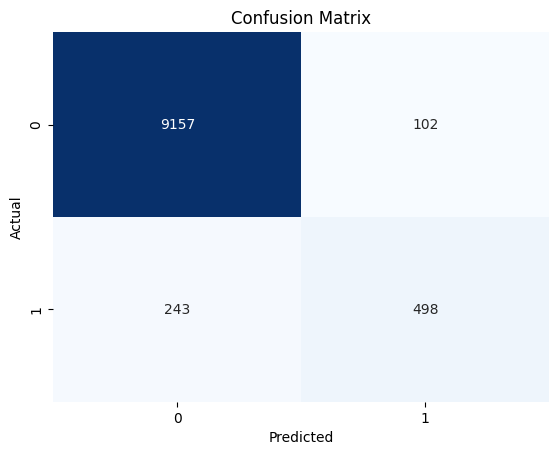

In [ ]:
# Create heatmap plot of confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 8.3 MB/s eta 0:00:00


In [ ]:

# make sure the SHAP values add up to marginal predictions
pred = xgb_model.predict(X_test, output_margin=True)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
np.abs(shap_values.sum(1) + explainer.expected_value - pred).max()

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


6.67572e-06

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


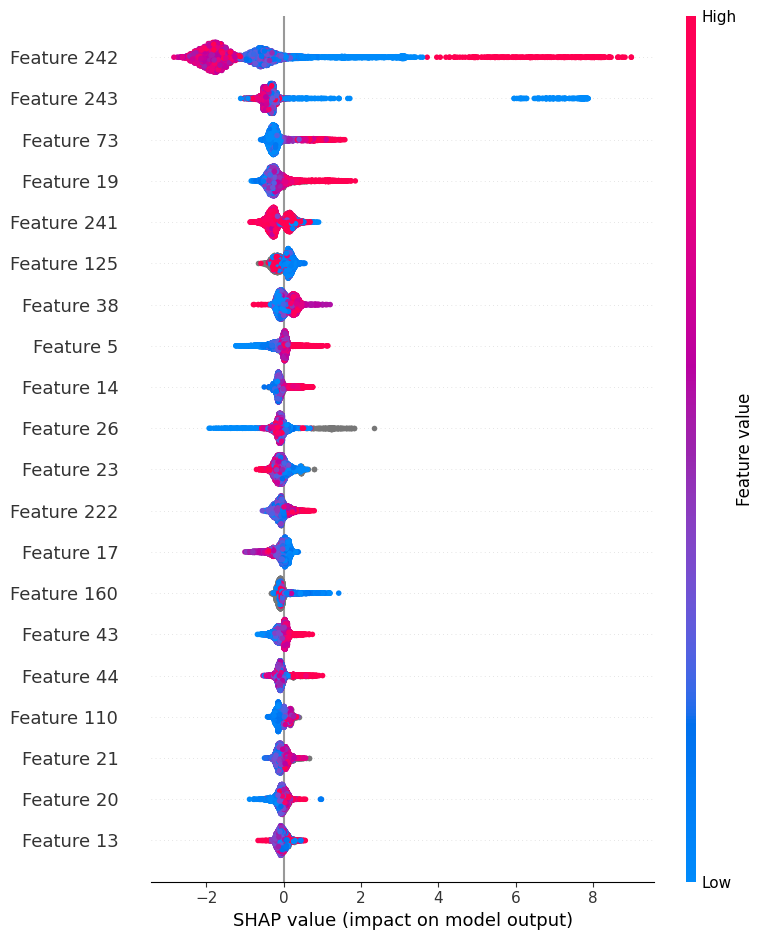

In [ ]:
shap.summary_plot(shap_values, X_test)


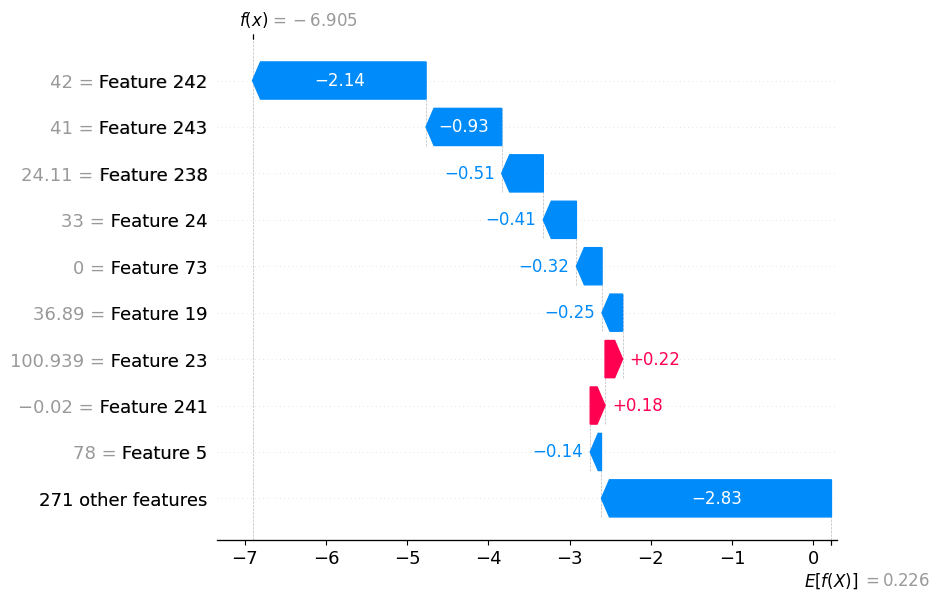

In [ ]:
import shap

# Create SHAP explainer object
explainer = shap.Explainer(clf)

# Compute SHAP values for test set
shap_values = explainer(X_test)

# Plot SHAP values for a single instance
shap.plots.waterfall(shap_values[0])

In [ ]:
X_test = test_agg.drop(('SepsisLabel','last'), axis=1)

X_test.iloc[:,14]


Patient_ID
patient_0       37.00
patient_1       37.28
patient_10      37.61
patient_100     37.56
patient_1000    38.83
                ...  
patient_9995    37.90
patient_9996    36.50
patient_9997    37.25
patient_9998    37.00
patient_9999    37.28
Name: (Temp, max), Length: 10000, dtype: float64

In [ ]:
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier, cv, Pool
from sklearn.model_selection import RandomizedSearchCV


train_pool = Pool(data=X_train_resampled, label=y_train_resampled)
test_pool = Pool(data=X_test, label=y_test)

param_grid = {
    'iterations': [100, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
    'border_count': [32, 64, 128],
    'random_strength': [0.1, 0.5, 1],
    'bagging_temperature': [0, 1, 10],
}

clf = CatBoostClassifier(eval_metric='F1')
random_search = RandomizedSearchCV(
    clf, 
    param_distributions=param_grid, 
    n_iter=10, 
    cv=[(train_pool, test_pool)], 
    verbose=3, 
    scoring='f1'
)
random_search.fit((X_train_resampled, y_train_resampled), eval_set=(X_test, y_test))

model = CatBoostClassifier(**random_search.best_params_, eval_metric='F1')
model.fit(X_train_resampled, y_train_resampled, eval_set=(X_test, y_test))



Fitting 1 folds for each of 10 candidates, totalling 10 fits


ValueError: ignored

In [ ]:
import lightgbm as lgb

# Create a LightGBM dataset


# Define hyperparameters
params = {'num_leaves': 150,
 'learning_rate': 0.02,
 'feature_fraction': 0.9378537303583372,
 'bagging_fraction': 0.9990828605870183,
 'bagging_freq': 2,
 'min_child_samples': 31,
 'num_iterations': 400}

X_train = train_agg.drop(('SepsisLabel','last'), axis=1)
y_train = train_agg[('SepsisLabel','last')].values
X_test = test_agg.drop(('SepsisLabel','last'), axis=1)
y_test = test_agg[('SepsisLabel','last')].values

# X_train = train_agg.drop(('SepsisLabel','last'), axis=1).values
# y_train = train_agg[('SepsisLabel','last')].values
# X_test = test_agg.drop(('SepsisLabel','last'), axis=1).values
# y_test = test_agg[('SepsisLabel','last')].values


# Resample the data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


train_data = lgb.Dataset(X_train_resampled, label=y_train_resampled)

# Train the model
model = lgb.train(params, train_data)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the predictions to binary
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]

# Evaluate the model's performance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Accuracy:', accuracy_score(y_test, y_pred_binary))
print('Precision:', precision_score(y_test, y_pred_binary))
print('Recall:', recall_score(y_test, y_pred_binary))
print('F1 score:', f1_score(y_test, y_pred_binary))






/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


AttributeError: ignored

In [ ]:
!pip install optuna

In [ ]:
import optuna.integration.lightgbm as optuna_lgb
import optuna
from optuna.samplers import TPESampler
import pickle
from sklearn import metrics

# Create an Optuna study
study = optuna.create_study(study_name='lgbm', direction='minimize')

# Define the LightGBM objective function for Optuna
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'logloss',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 10, 200),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.5),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        "feature_pre_filter":False,
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 100),
        "num_iterations" :trial.suggest_int( "num_iterations", 100, 300)

    }
    
    # Train the LightGBM model
    model = lgb.train(params, train_data)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]
    
    # Calculate the multi-class logarithmic loss
    loss = metrics.log_loss(y_test, y_pred)
    
    return loss

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)

# Run the hyperparameter optimization using Optuna
study.optimize(objective, n_trials=100, n_jobs=1)

# Get the best hyperparameters from the optimization
best_params = study.best_params

In [ ]:
best_params

{'num_leaves': 15,
 'learning_rate': 0.04591051406089763,
 'feature_fraction': 0.9378537303583372,
 'bagging_fraction': 0.9990828605870183,
 'bagging_freq': 2,
 'min_child_samples': 31,
 'num_iterations': 243}

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

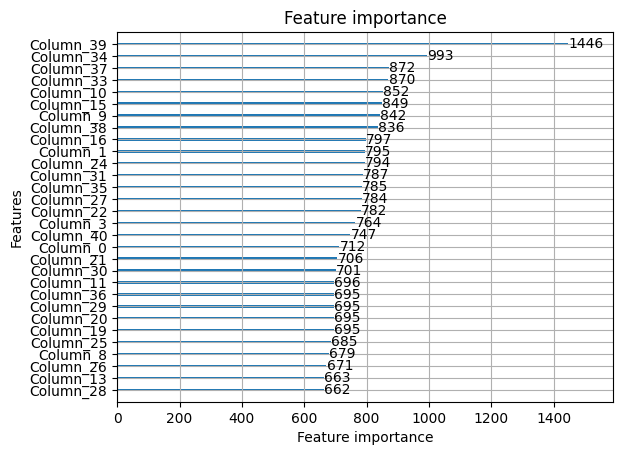

In [ ]:
lgb.plot_importance(model, max_num_features=30)
